# Predict female behav vars from hand-picked song features

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import sys

from disp import set_plot
from my_torch import skl_fit_lin_single

cc = np.concatenate


TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

PFX_BHV = f'data/simple/behav_xtd/behav_xtd'

SONG_HEURS = [
    'N_S_ONSETS',
    'N_P_ONSETS',
    'N_B_ONSETS',
    'S_TOTAL',
    'P_TOTAL',
    'B_TOTAL',
    # duration/ratio vars are undefined at many timepoints, which significantly changes the dataset used for fitting
    'MN_S_DUR',
    'MN_P_DUR',  
    'MN_B_DUR',
#     'SP_RATIO',
]
WDWS_HEUR = [1, 10, 30, 60, 120, 240, 480, 1800]

PTRAIN = .8
NSPLIT = 30

MASK_PFX = 'data/simple/masks/mask'
# MASK_PFX = None

if MASK_PFX:
    FSAVE_SFX = f'{TARG_BHV.lower()}_masked'
else:
    FSAVE_SFX = f'{TARG_BHV.lower()}'

In [2]:
STRAINS = ['NM91', 'ZH23']
# STRAINS = ['CM07', 'CSTul', 'N30', 'ZW109']
# STRAINS = ['NM91', 'ZH23', 'CM07', 'CSTul', 'N30', 'ZW109']
# STRAINS = ['WTG']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = len(ISTRAIN)
NTRAIN = int(round(PTRAIN*NTR))

In [3]:
PFX_NRL = f'data/simple/mlv/heuristic/heuristics/heuristics'

COLS_USE = ['T'] + sum([[f'{kheur}_{wdw}' for wdw in WDWS_HEUR] for kheur in SONG_HEURS], [])

FSAVE = f'data/simple/mlv/heuristic/heuristics_single_{STRAIN_KEY}_{FSAVE_SFX}.npy'

In [4]:
# fit model
rslt = skl_fit_lin_single(
    pfxs=[PFX_NRL, PFX_BHV],
    cols_x=COLS_USE,
    targs=TARGS,
    itr_all=ISTRAIN,
    ntrain=NTRAIN,
    nsplit=NSPLIT,
    mask_pfx=MASK_PFX,
    verbose=True)

# save results
save_data = {
    'r2_train': rslt.r2_train,
    'r2_test': rslt.r2_test,

    'w': rslt.w,
    'bias': rslt.bias,

    'targs': TARGS,
    'heurs': COLS_USE,

    'ntr': NTR,
    'ntrain': NTRAIN,
    'nsplit': NSPLIT
}

np.save(FSAVE, np.array([save_data]))


Loading...
Splits:
>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....>.....

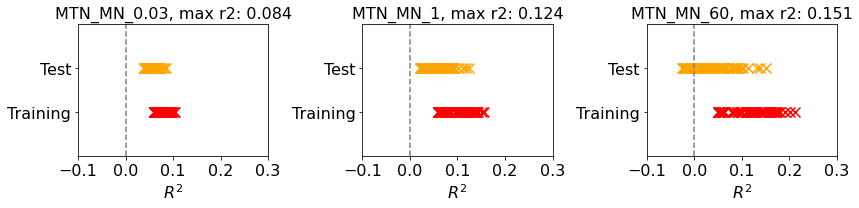

In [5]:
data = np.load(FSAVE, allow_pickle=True)[0]

fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)

for ax, targ, in zip(axs, TARGS):

    r2_train = data['r2_train'][targ].mean(axis=0)  # avg over splits
    r2_test = data['r2_test'][targ].mean(axis=0)  
    r2_test_max = np.max(r2_test)

    ax.scatter(r2_train, np.zeros(len(r2_train)), c='r', marker='x', s=100)
    ax.scatter(r2_test, np.ones(len(r2_test)), c='orange', marker='x', s=100)

    ax.axvline(0, color='gray', ls='--')

    set_plot(
        ax, (-.1, .3), y_lim=(-1, 2), y_ticks=[0, 1], 
        y_tick_labels=['Training', 'Test'], x_label=r'$R^2$', title=f'{targ}, max r2: {r2_test_max:.3f}', font_size=16)

# Print out table of mean test R2 for diff song feats

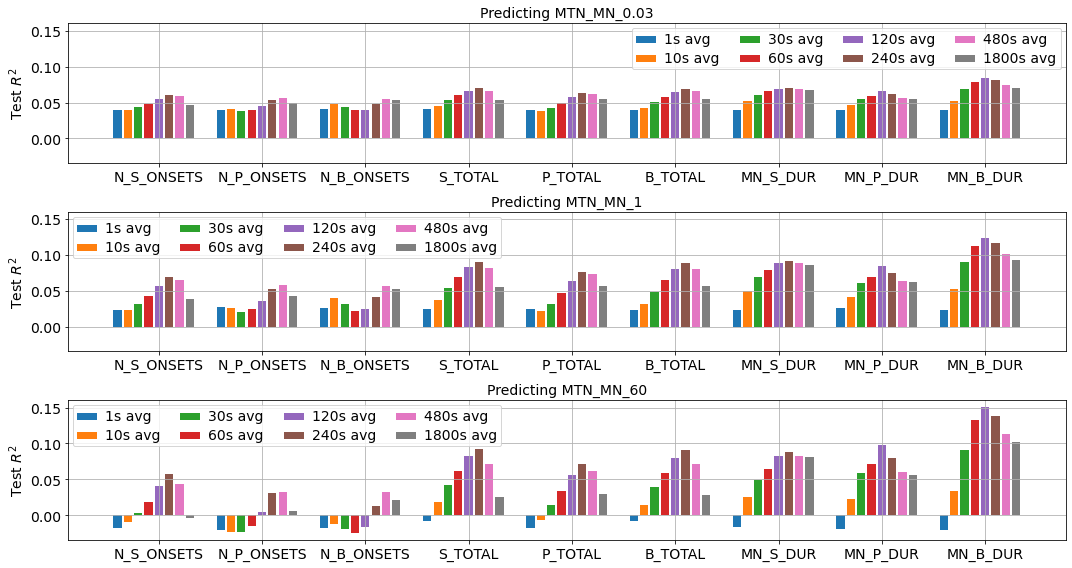

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axs = plt.subplots(3, 1, figsize=(15, 8), tight_layout=True, sharey=True)

for targ, ax in zip(TARGS, axs):
    r2_test = data['r2_test'][targ].mean(axis=0)
    
    x_ticks = []
    
    for cfeat, feat in enumerate(SONG_HEURS):
        for cwdw, (wdw, color) in enumerate(zip(WDWS_HEUR, colors)):
            
            icol = data['heurs'].index(f'{feat}_{wdw}')
            ax.bar(cfeat + .1*cwdw, r2_test[icol], width=.08, color=color)
        
        x_ticks.append(cfeat+ .4)
        
    ax.legend([f'{wdw}s avg' for wdw in WDWS_HEUR], ncol=4)
    ax.grid()
    
    set_plot(ax, x_ticks=x_ticks, x_tick_labels=SONG_HEURS, y_label=r'Test $R^2$', title=f'Predicting {targ}', font_size=14)